Package importation

In [ ]:
import sys
from packaging import version
import matplotlib.animation
import matplotlib.pyplot as plt
from pathlib import Path
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random


assert sys.version_info >= (3, 7)

if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gym
    %pip install -q -U gym[classic_control,box2d,atari,accept-rom-license]

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
ERROR: Could not build wheels for box2d-py, which is required to install pyproject.toml-based projects


Class and Functions

In [ ]:
IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("MountainCar-v0", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

In [ ]:
class FlexibleMLP(nn.Module):
    def __init__(self, layers):
        super(FlexibleMLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        for i in range(len(layers) - 1):
            layer = nn.Linear(layers[i], layers[i+1])

            # LeCun initialization
            nn.init.normal_(layer.weight, mean=0.0, std=np.sqrt(1 / layers[i]))
            nn.init.normal_(layer.bias, mean=0.0, std=np.sqrt(1 / layers[i]))

            self.layers.append(layer)
            # Add ReLU activation after each layer except the last
            if i < len(layers) - 2:
                self.activations.append(nn.ReLU())
            else:
                # Placeholder for the last layer's activation
                self.activations.append(nn.Sigmoid())

    def forward(self, x, return_last_hidden=False):
        last_hidden = None

        for layer, activation in zip(self.layers[:-1], self.activations[:-1]):
            x = activation(layer(x))
            last_hidden = x  # Update last_hidden at each hidden layer

        # Apply the last layer without ReLU (or Identity for the placeholder)
        x = self.layers[-1](x)

        if return_last_hidden:
            return x, last_hidden
        return x

    def set_seed(seed_value=42):
      """Set seed for reproducibility."""
      np.random.seed(seed_value)  # Set NumPy seed
      torch.manual_seed(seed_value)  # Set PyTorch seed
      random.seed(seed_value)  # Set Python random seed

      # If you are using CUDA:
      if torch.cuda.is_available():
          torch.cuda.manual_seed(seed_value)
          torch.cuda.manual_seed_all(seed_value)  # For multi-GPU
          torch.backends.cudnn.deterministic = True
          torch.backends.cudnn.benchmark = False

In [ ]:
def train_model(num_epochs: int,
                train_loader: DataLoader,
                criterion,
                optimizer,
                model):
  # Training loop
  for epoch in range(num_epochs):
      for inputs, targets in train_loader:
          # Forward pass
          outputs = model(inputs) #input à l'objet qui donne output
          loss = criterion(outputs, targets) #criterion = loss function

          # Backward and optimize
          optimizer.zero_grad() # kill old gradients
          loss.backward() # compute new gradients
          optimizer.step() # perform the step of gradient descent

      if (epoch+1) % 20 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [ ]:
def play_one_step(env, obs, model, loss_fn):
    obs = torch.tensor(obs[np.newaxis], dtype=torch.float32)
    model.train()
    with torch.enable_grad():
        left_proba = model(obs)
        action = (torch.rand(1, 1) > left_proba).float()
        y_target = torch.tensor([[1.]]) - action
        loss = torch.mean(loss_fn(left_proba, y_target))


    grads = [param.grad for param in model.parameters() if param.grad is not None]

    obs, reward, done, truncated, info = env.step(int(action.item()))
    model.zero_grad()

    return obs, reward, done, truncated, grads


In [ ]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

In [ ]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

General Settings and Environment setup

In [ ]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

In [ ]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")

In [ ]:
obs, info = env.reset(seed=42)

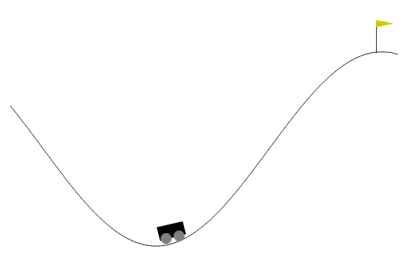

In [ ]:
plot_environment(env)
plt.show()

In [ ]:
FlexibleMLP.set_seed(42)
width = 100
model_architecture = [obs.shape[1], width, 2] #premier layer = nombre de parametre, second = 100 arbitraire, dernier = 1 pour donner une fonction
model = [FlexibleMLP(model_architecture)] #Chaque model possède la mêm architecture / modèle devient un objet flexible mlp

In [ ]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

loss_fn = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    # extra code – displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

In [ ]:
# Initialize the deep neural network model
num_seeds = 20 #on test avec differentes seed le model

FlexibleMLP.set_seed(42)
width = 100
model_architecture = [X_train.shape[1], width, 1] #premier layer = nombre de parametre, second = 100 arbitraire, dernier = 1 pour donner une fonction
models = [FlexibleMLP(model_architecture) for seed in range(num_seeds)] #Chaque model possède la mêm architecture / modèle devient un objet flexible mlp

# Proceed with the rest of the setup (loss, optimizer) and training loop as before
# Loss and optimizer
for seed in range(num_seeds): #Un model pour chaque seed

  FlexibleMLP.set_seed(seed)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(models[seed].parameters(), lr=0.0001) #, weight_decay=0)  # Using Adam optimizer for better performance with deep networks

  train_model(num_epochs=200,
              train_loader=train_loader,
              criterion=criterion,
              optimizer=optimizer,
              model=models[seed])